In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import torch
from tqdm.notebook import tqdm

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import sys
sys.path.append('..')

In [2]:
from utils import plot_attention_weights

In [3]:
from transformers import BertTokenizer
# custom bert model. Returns hiddens for each head if output_attentions=True
from modeling_bert import BertModel

In [4]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
texts = ["Hello, my dog is cute. Her name is Daisy. She loves to run.", 'hey']
inputs = tokenizer.batch_encode_plus(texts, padding=True, add_special_tokens=True, truncation=True)
for k in inputs:
    inputs[k] = torch.tensor(inputs[k], requires_grad=False).cuda()
inputs

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,  1012,  2014,  2171,
          2003, 10409,  1012,  2016,  7459,  2000,  2448,  1012,   102],
        [  101,  4931,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')}

In [6]:
model.zero_grad()
output = model(**inputs, output_attentions=True, output_hidden_states=True)
output.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

In [7]:
tokens = [[tokenizer.convert_ids_to_tokens(t).replace('▁', '') for t in inputs['input_ids'][i].tolist()] for i in range(len(inputs['input_ids']))]
print('\n'.join([' '.join(t) for t in tokens]))

[CLS] hello , my dog is cute . her name is daisy . she loves to run . [SEP]
[CLS] hey [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [8]:
# layer, 0 - hiddens:    bs x seq_len x hidden
# layer, 1 - attentions: bs x n_heads x seq_len x seq_len 
layer = 1
print(output['attentions'][layer][0].shape)
print(output['attentions'][layer][1].shape)

torch.Size([2, 19, 768])
torch.Size([2, 12, 19, 19])


In [9]:
# todo: cut seq_len to actual sequence length?
attentions = np.array([attn[1][0].detach().squeeze().cpu().numpy() for attn in output['attentions']])
attentions.shape # n_layes x n_heads x seq_len x seq_len

(12, 12, 19, 19)

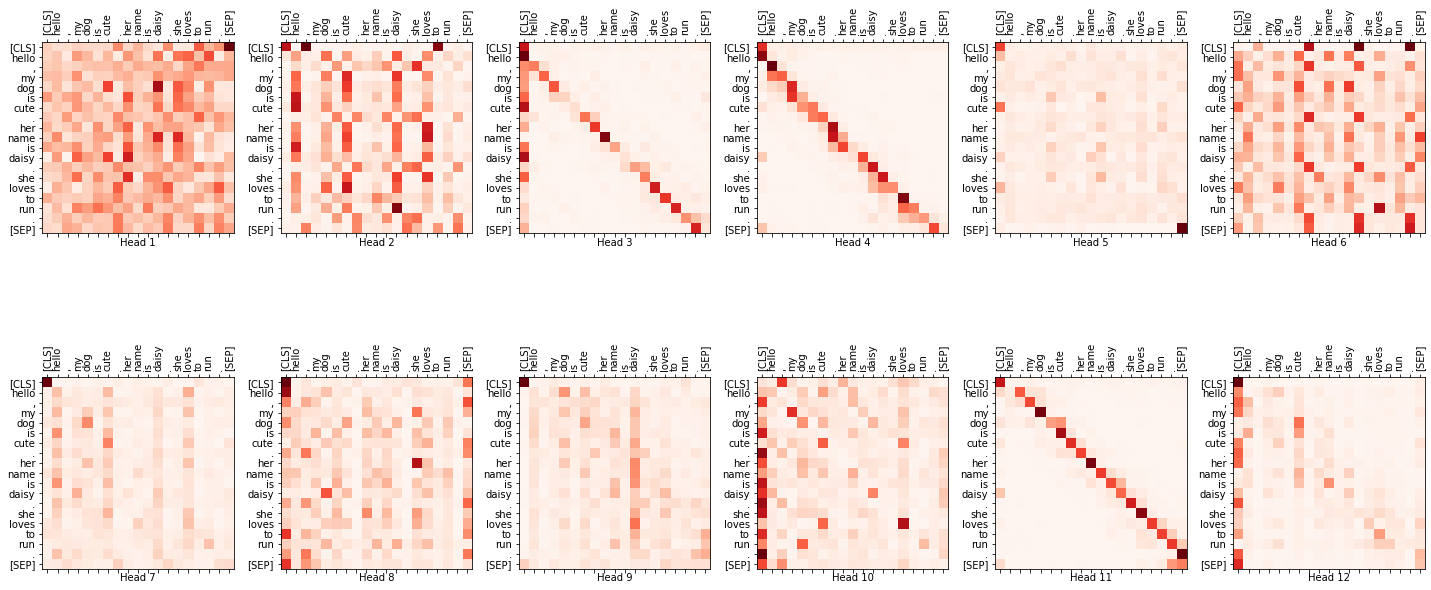

In [10]:
# layer 0 attention heads
plot_attention_weights(attentions, tokens[0], layer=0, layout=(2,6), figsize=(20,10))

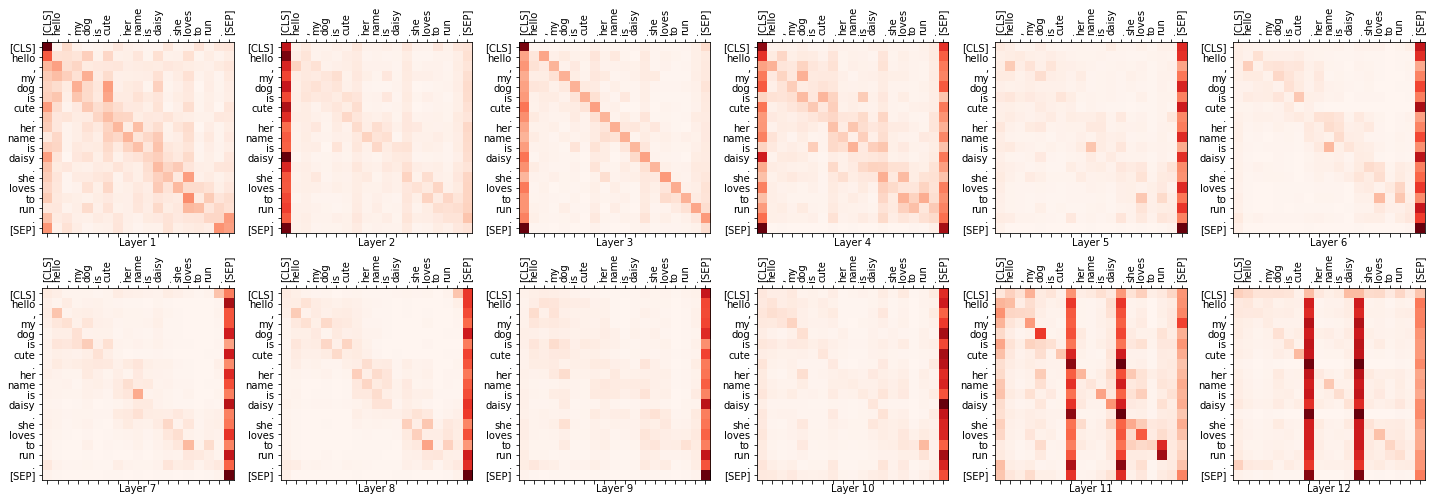

In [11]:
# avg att per layer
avg_per_layer_att = attentions.mean(axis=1)
plot_attention_weights([avg_per_layer_att], tokens[0], layer=0, layout=(2,6), figsize=(20,7), caption='Layer')

In [12]:
# gradient based attention maps

In [13]:
from utils import grad_layer_attention_map

In [14]:
texts = ["Hello, my dog is cute. Her name is Daisy. She loves to run."]
inputs = tokenizer.batch_encode_plus(texts, padding=True, add_special_tokens=True, truncation=True)

for k in inputs:
    inputs[k] = torch.tensor(inputs[k], requires_grad=False).cuda()
    
tokens = [[tokenizer.convert_ids_to_tokens(t).replace('▁', '') for t in inputs['input_ids'][i].tolist() if t != tokenizer.pad_token_id] for i in range(len(inputs['input_ids']))]
    
model.zero_grad()
output = model(**inputs, output_attentions=True, output_hidden_states=True)
output.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

In [15]:
attention_maps = grad_layer_attention_map(model, inputs, output)

  0%|          | 0/12 [00:00<?, ?it/s]

In [16]:
grad_based_attentions = attention_maps[0]
tokens = tokens[0]

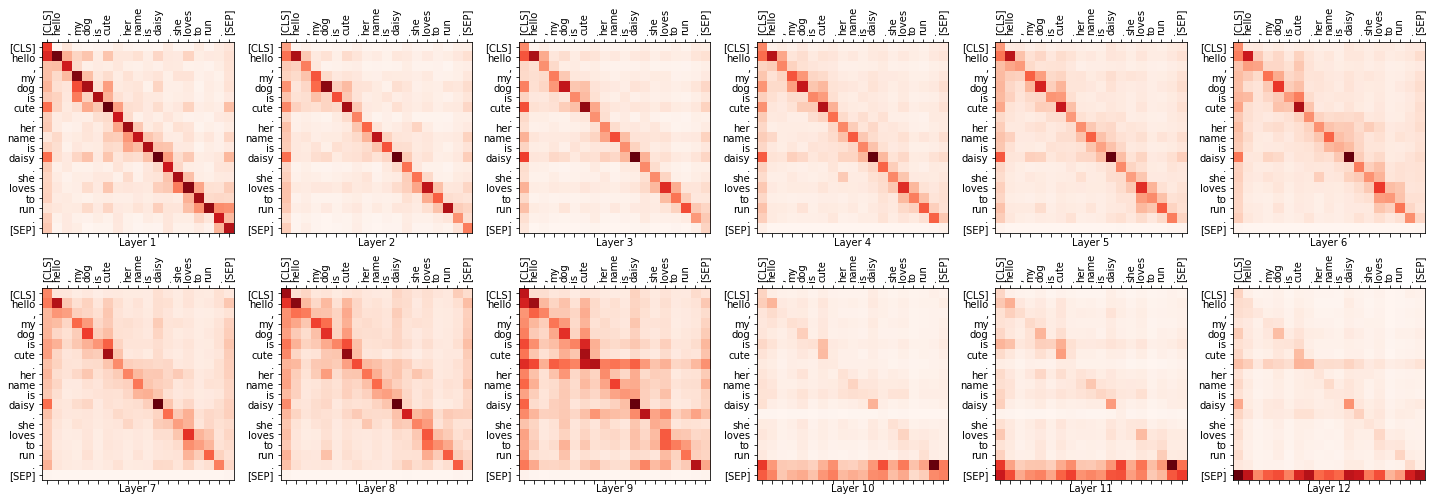

In [17]:
plot_attention_weights([grad_based_attentions], tokens, layer=0, layout=(2,6), figsize=(20,7), caption='Layer')
# plot_attention_weights([grad_based_attentions], tokens, layer=0, layout=(2,6), figsize=(20,7), caption='Layer',
#                        cmap='bwr', norm=mcolors.DivergingNorm(vcenter=0.0))

layer-avg attention maps:


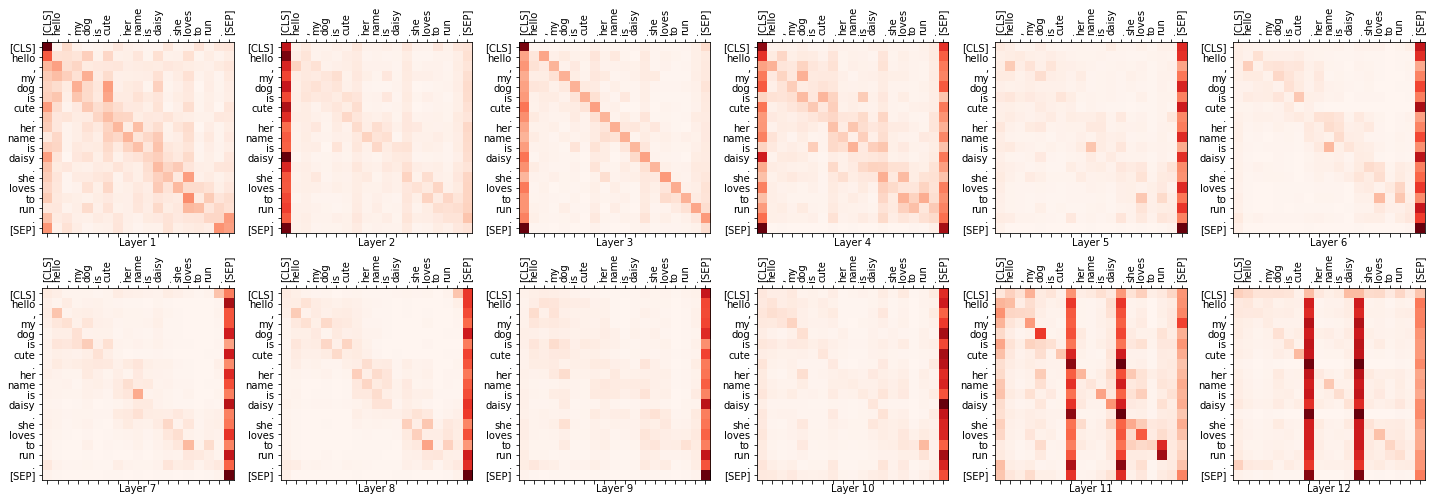

layer-avg grad-based attention maps:


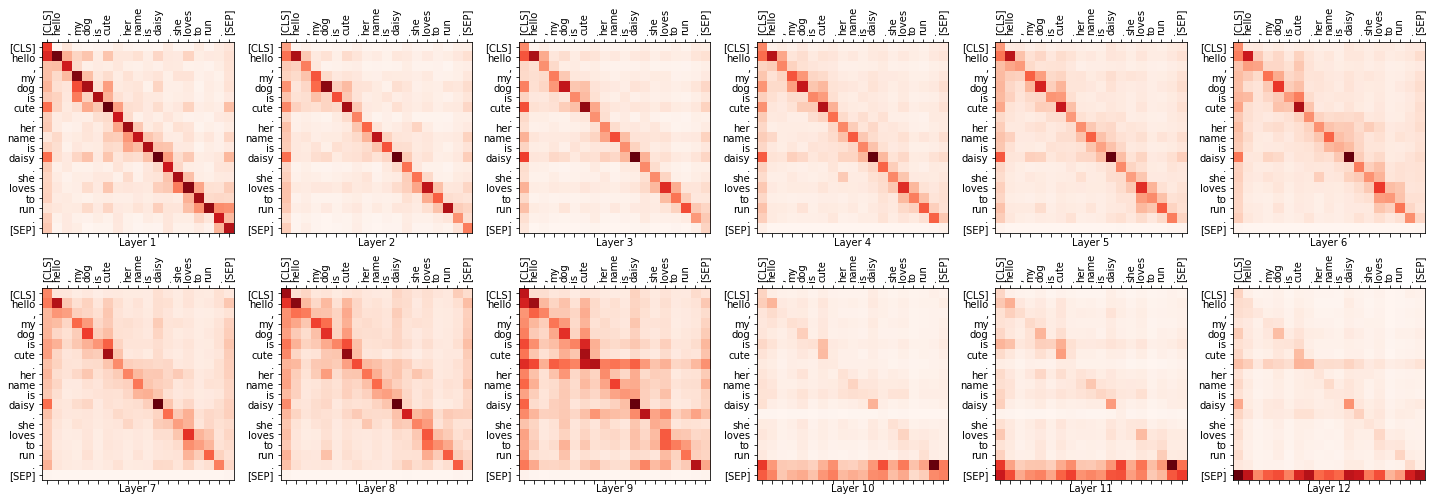

In [18]:
## compare
# avg att per layer
avg_per_layer_att = attentions.mean(axis=1)
print('layer-avg attention maps:')
plot_attention_weights([avg_per_layer_att], tokens, layer=0, layout=(2,6), figsize=(20,7), caption='Layer')
print('layer-avg grad-based attention maps:')
plot_attention_weights([grad_based_attentions], tokens, layer=0, layout=(2,6), figsize=(20,7), caption='Layer')

In [19]:
# grad for each hiddens_per_head

In [66]:
texts = ["Hello, my dog is cute. Her name is Daisy. She loves to run.", 'Hey']
inputs = tokenizer.batch_encode_plus(texts, padding=True, add_special_tokens=True, truncation=True)

for k in inputs:
    inputs[k] = torch.tensor(inputs[k], requires_grad=False).cuda()
    
tokens = [[tokenizer.convert_ids_to_tokens(t).replace('▁', '') for t in inputs['input_ids'][i].tolist() if t != tokenizer.pad_token_id] for i in range(len(inputs['input_ids']))]
    
model.zero_grad()
output = model(**inputs, output_attentions=True, output_hidden_states=True)
output.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

In [69]:
shape = output['attentions'][1][0].shape
# attn[0] -- per_head hiddens, not attention score
hiddens_per_head = torch.stack([attn[0].view(*shape[:-1], model.config.num_attention_heads, -1).permute(0, 2, 1, 3) for attn in output['attentions']])
# bs x n_layers x n_heads x seq_len x per_head_hidden
hiddens_per_head = hiddens_per_head.permute(1, 0, 2, 3, 4)
hiddens_per_head.shape

torch.Size([2, 12, 12, 19, 64])

In [70]:
from utils import grad_heads_attention_map

In [71]:
grad_based_attentions = grad_heads_attention_map(model, inputs, hiddens_per_head, output)

  0%|          | 0/12 [00:00<?, ?it/s]

In [72]:
grad_based_attentions = grad_based_attentions[0]
tokens = tokens[0]

In [73]:
grad_based_attentions[0].shape

(12, 19, 19)

Layer 0 attention maps:


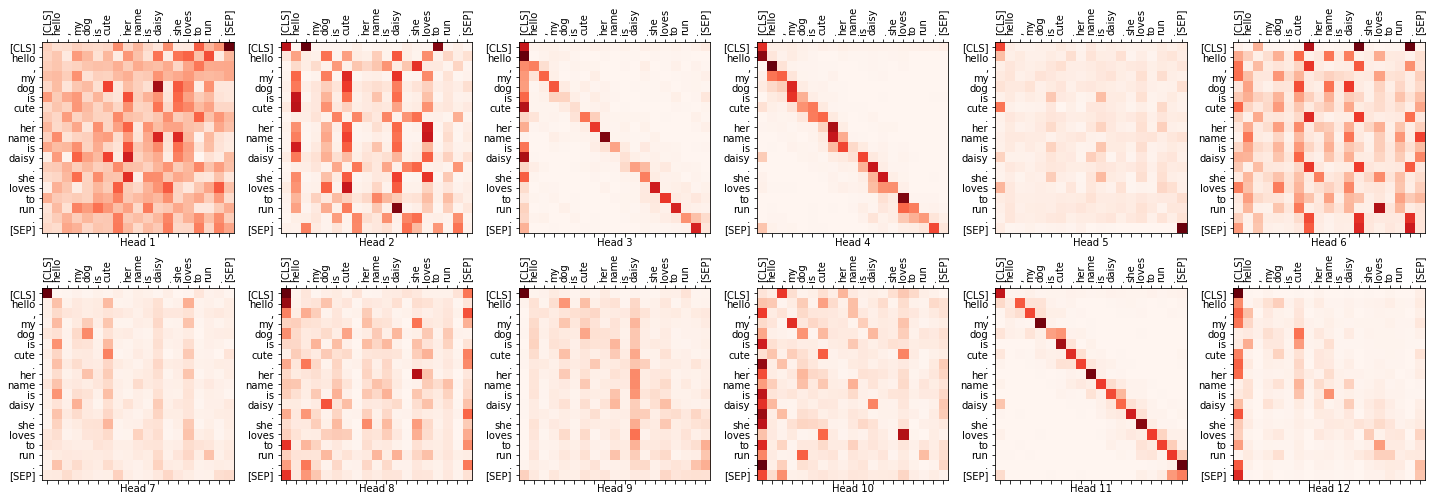

Layer 0 gradient based attention maps:


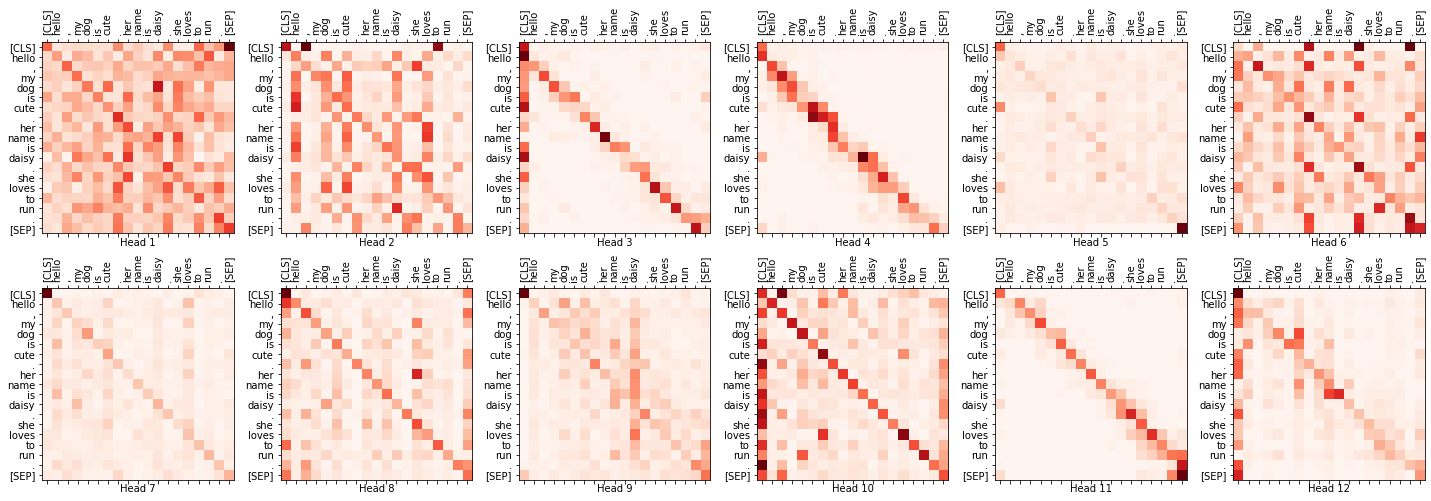

Layer 1 attention maps:


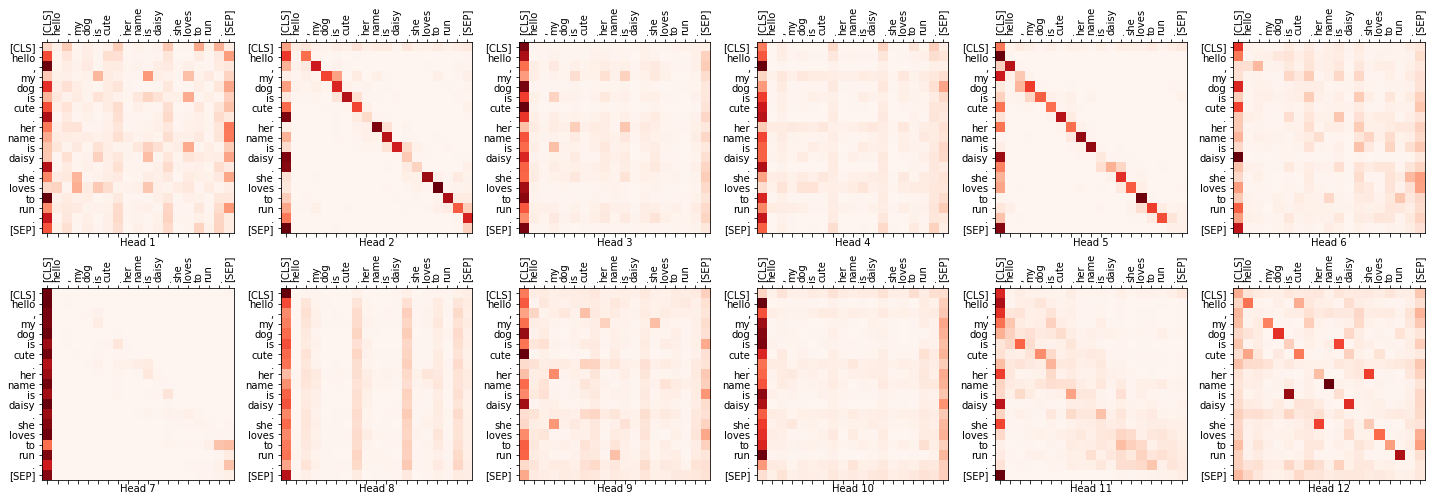

Layer 1 gradient based attention maps:


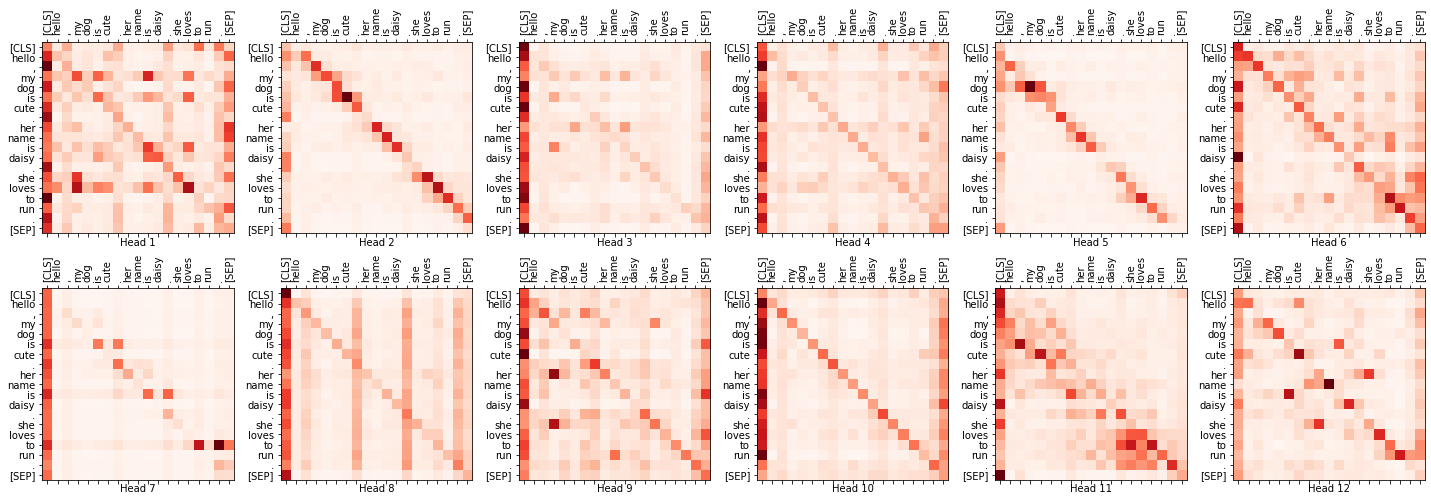

Layer 2 attention maps:


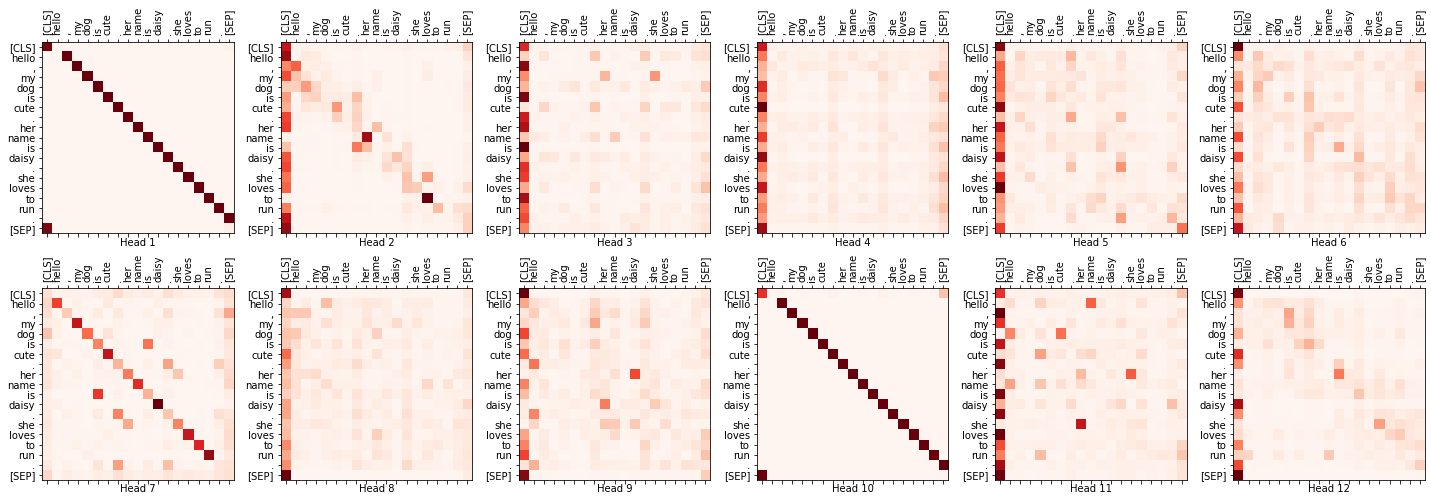

Layer 2 gradient based attention maps:


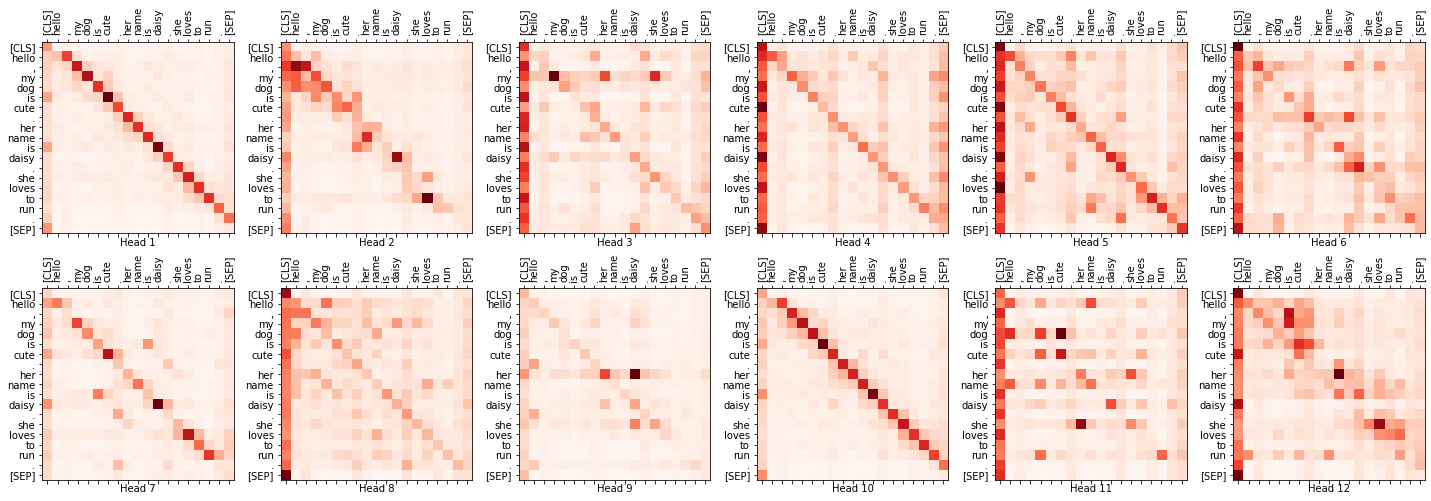

Layer 3 attention maps:


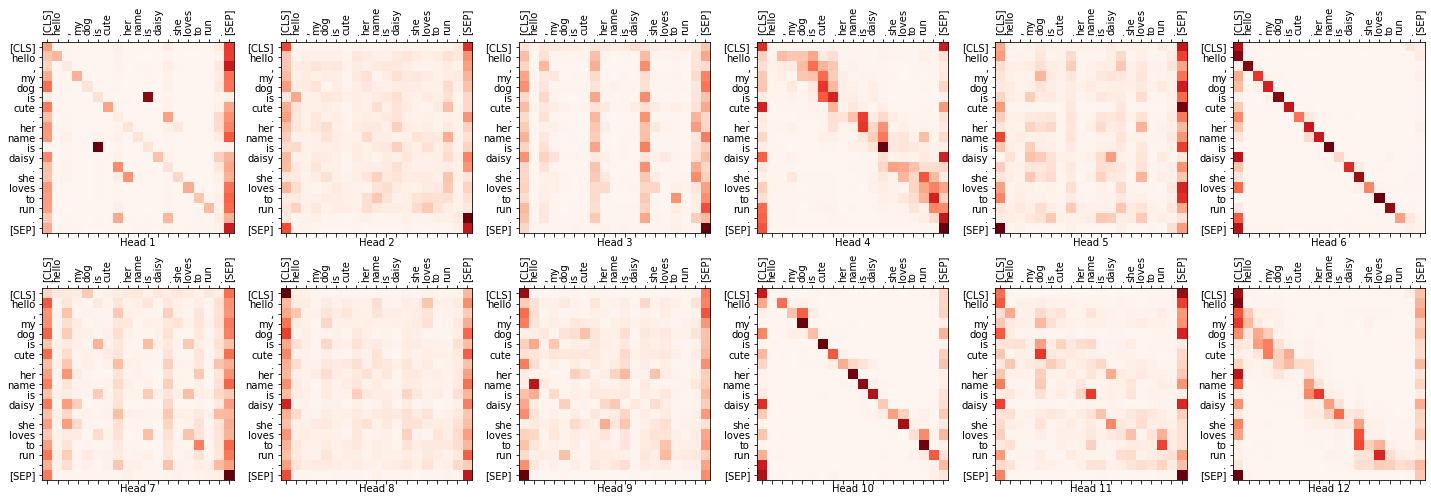

Layer 3 gradient based attention maps:


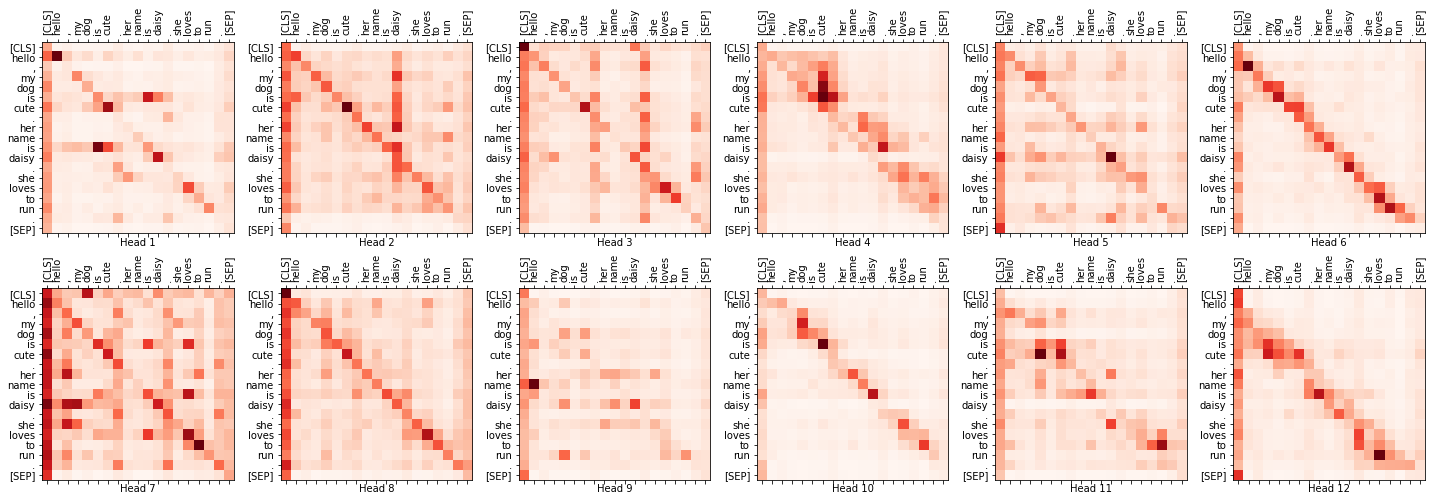

Layer 4 attention maps:


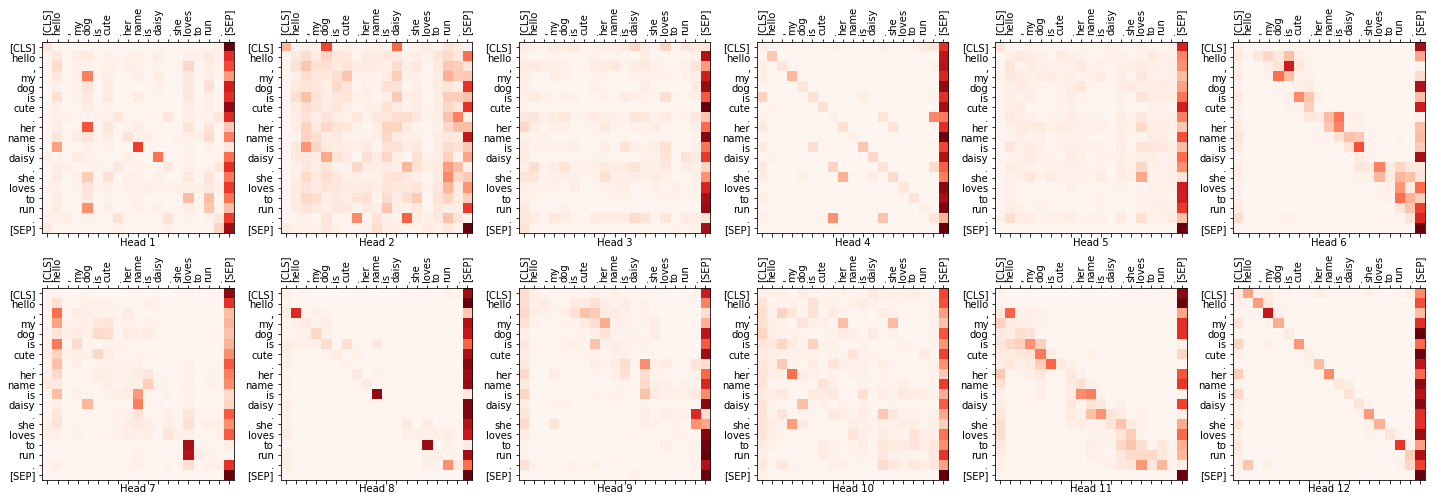

Layer 4 gradient based attention maps:


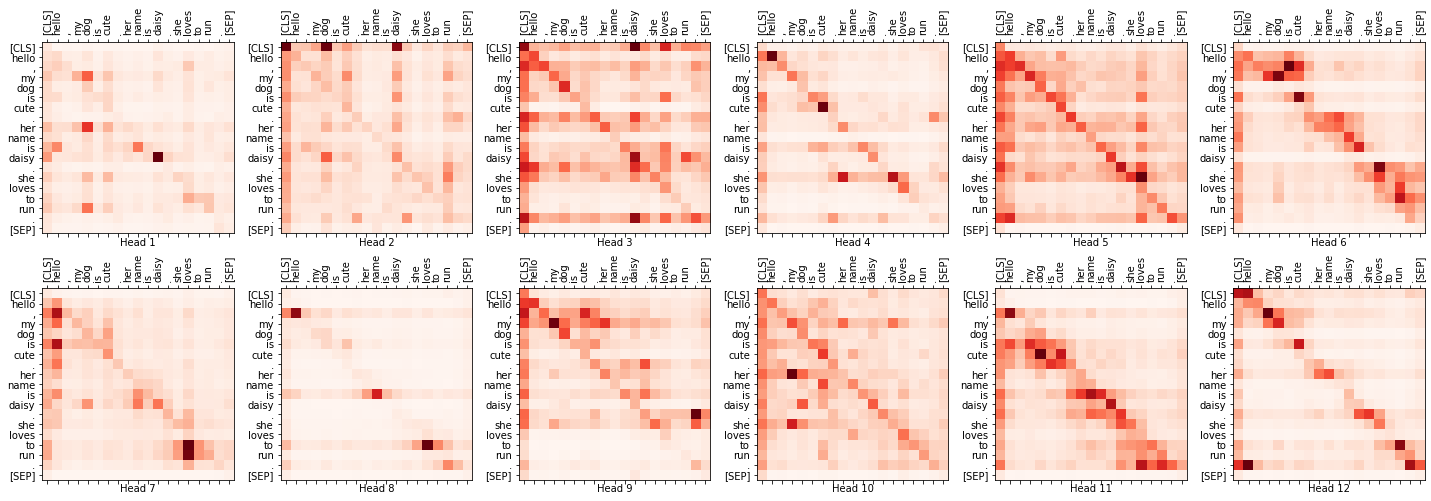

Layer 5 attention maps:


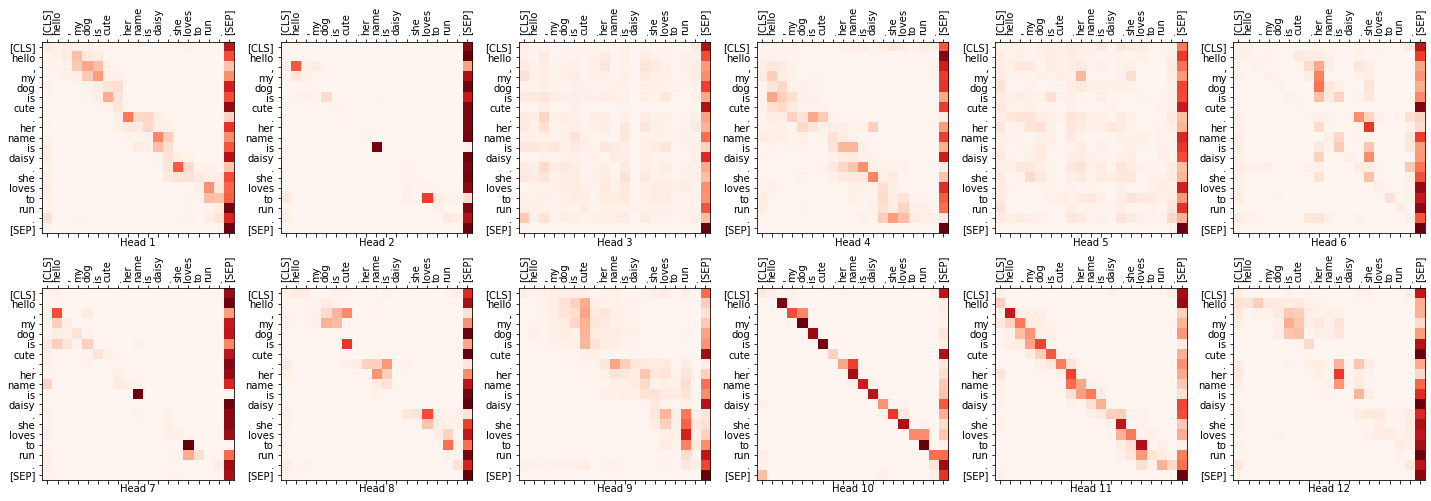

Layer 5 gradient based attention maps:


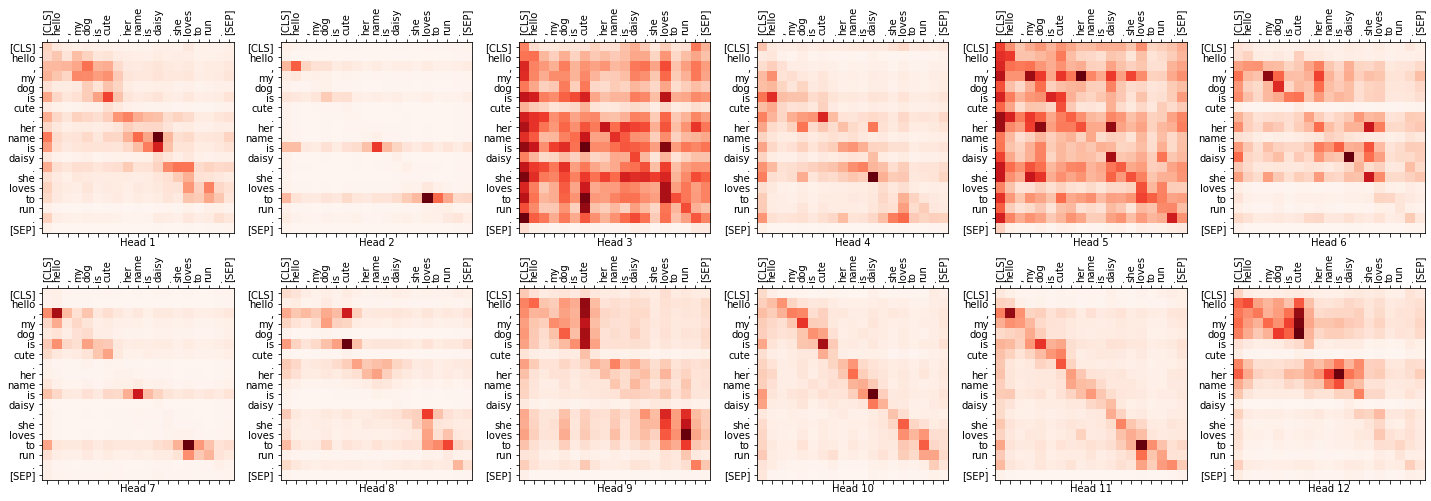

Layer 6 attention maps:


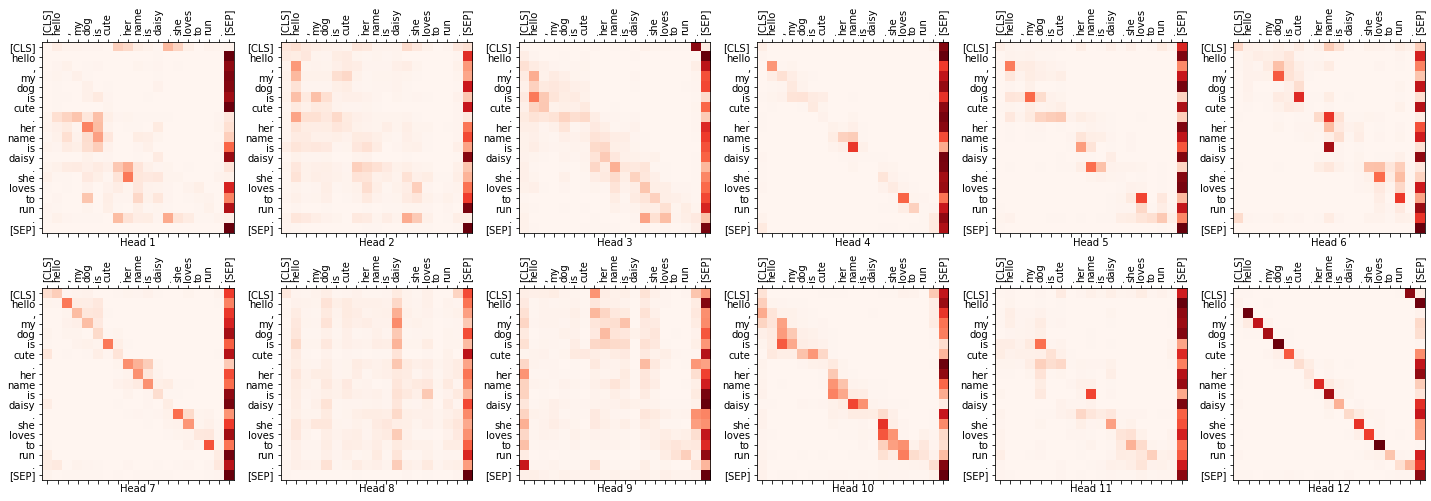

Layer 6 gradient based attention maps:


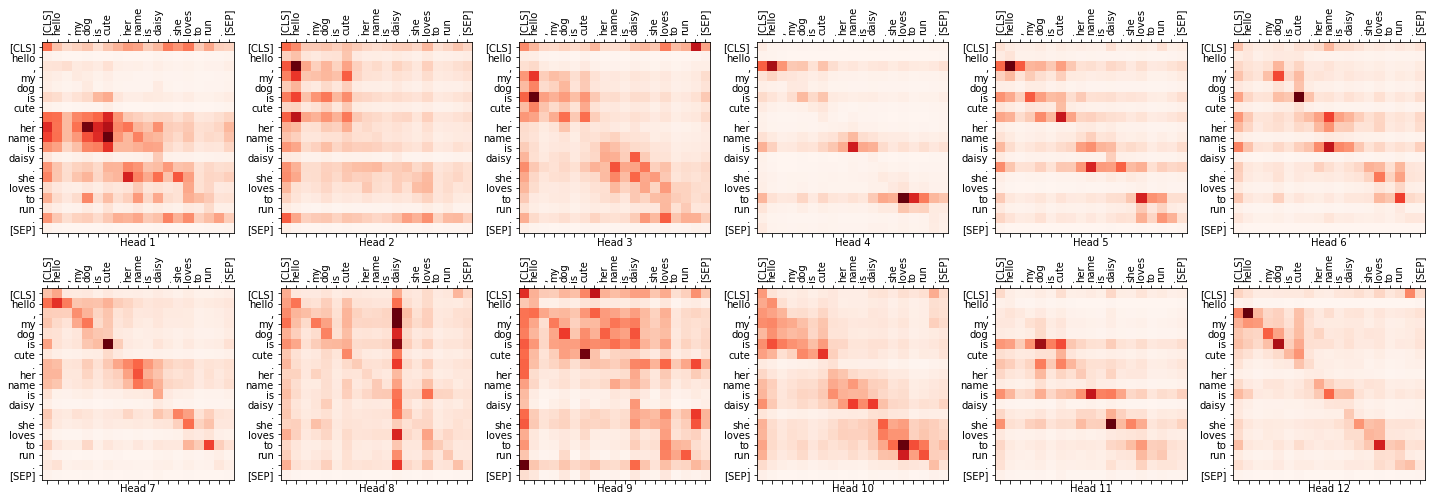

Layer 7 attention maps:


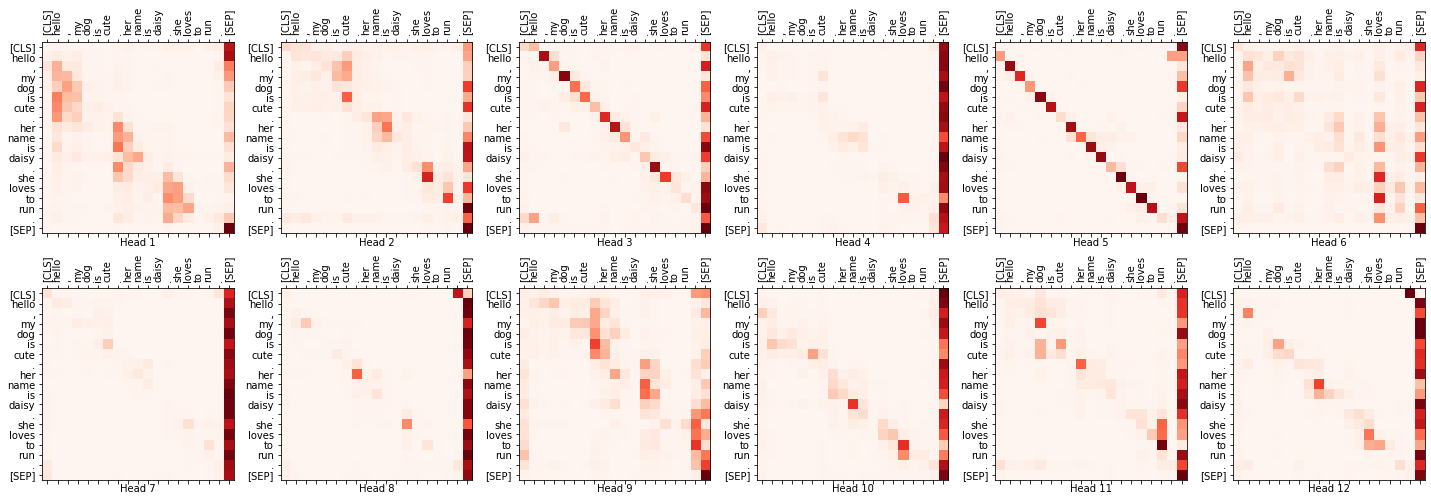

Layer 7 gradient based attention maps:


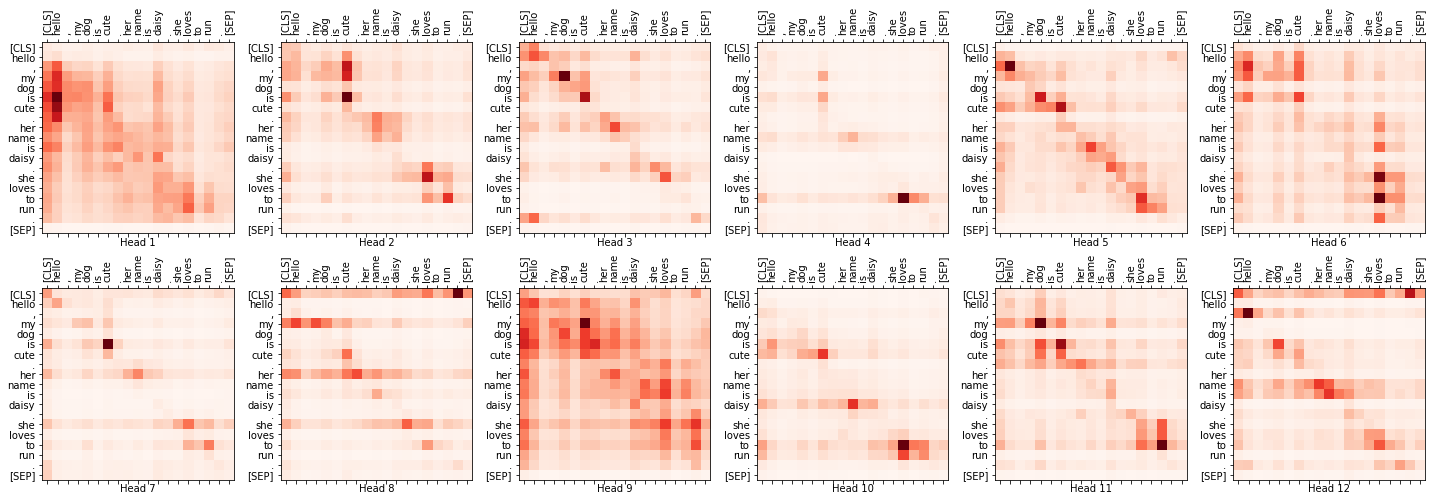

Layer 8 attention maps:


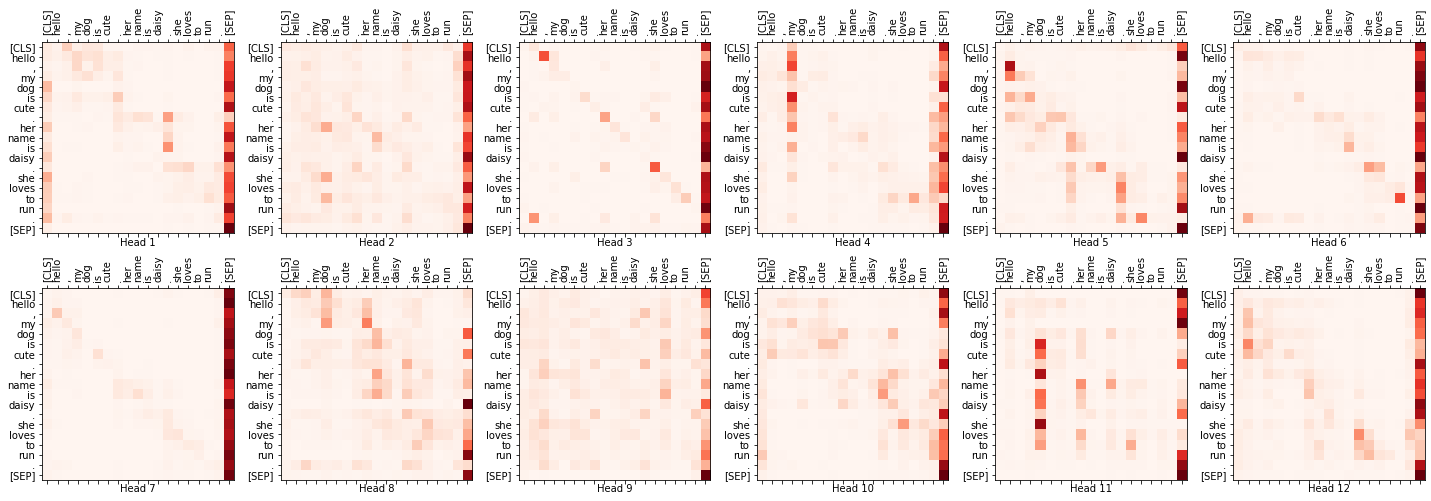

Layer 8 gradient based attention maps:


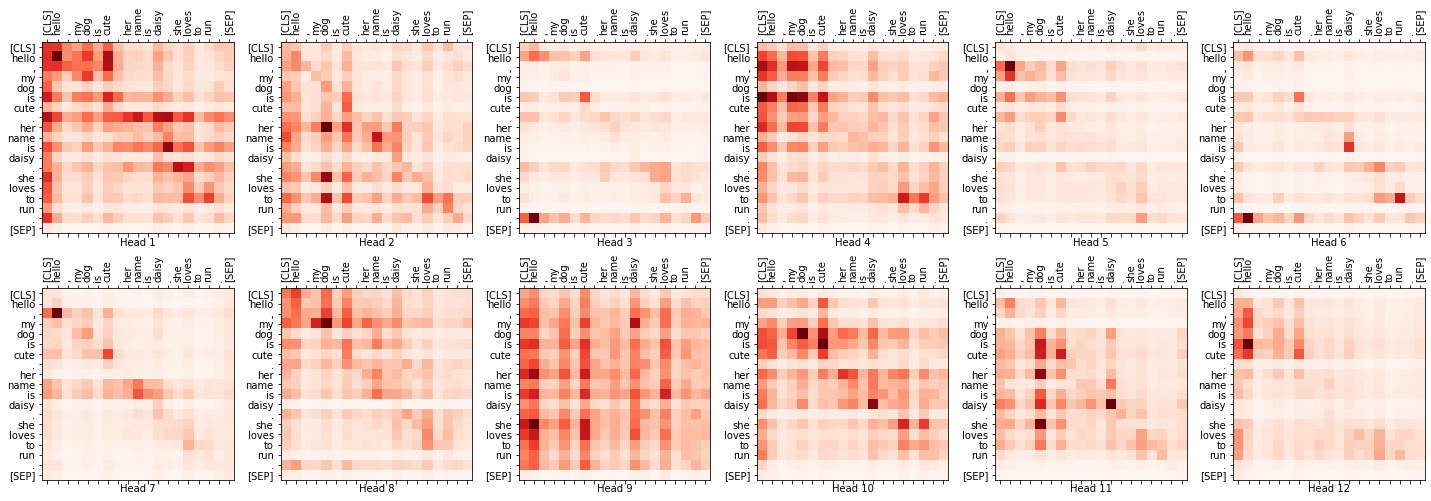

Layer 9 attention maps:


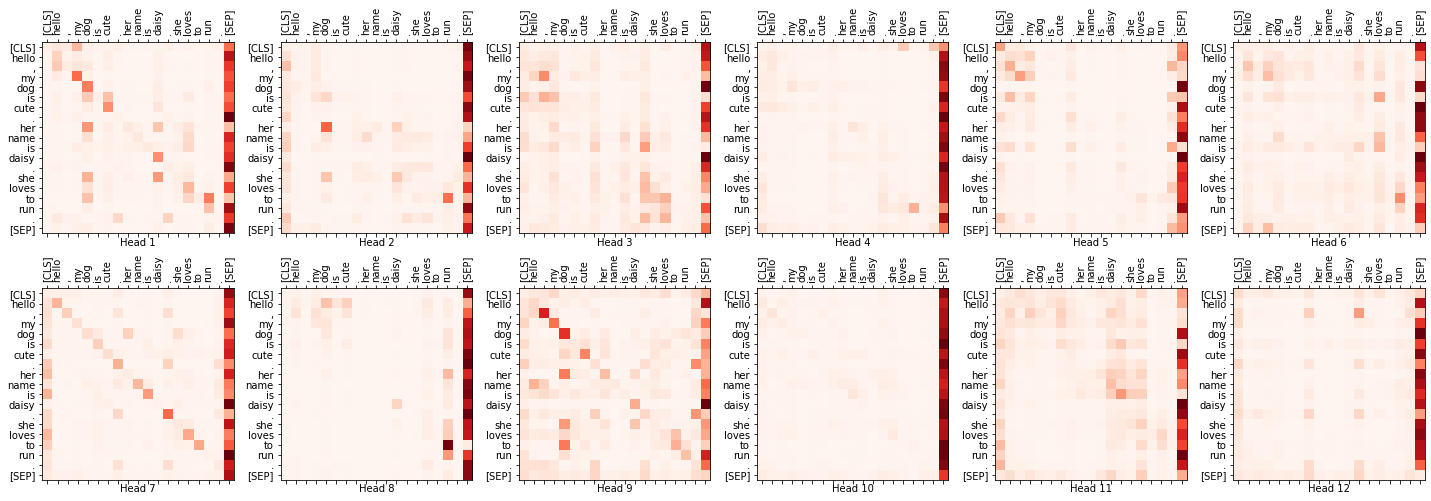

Layer 9 gradient based attention maps:


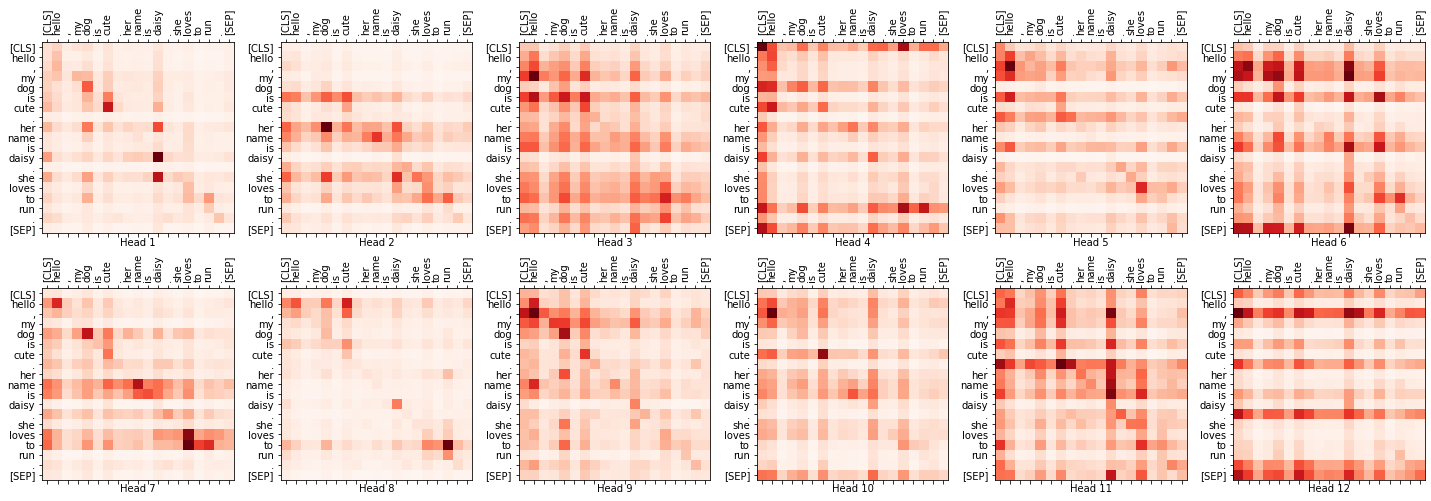

Layer 10 attention maps:


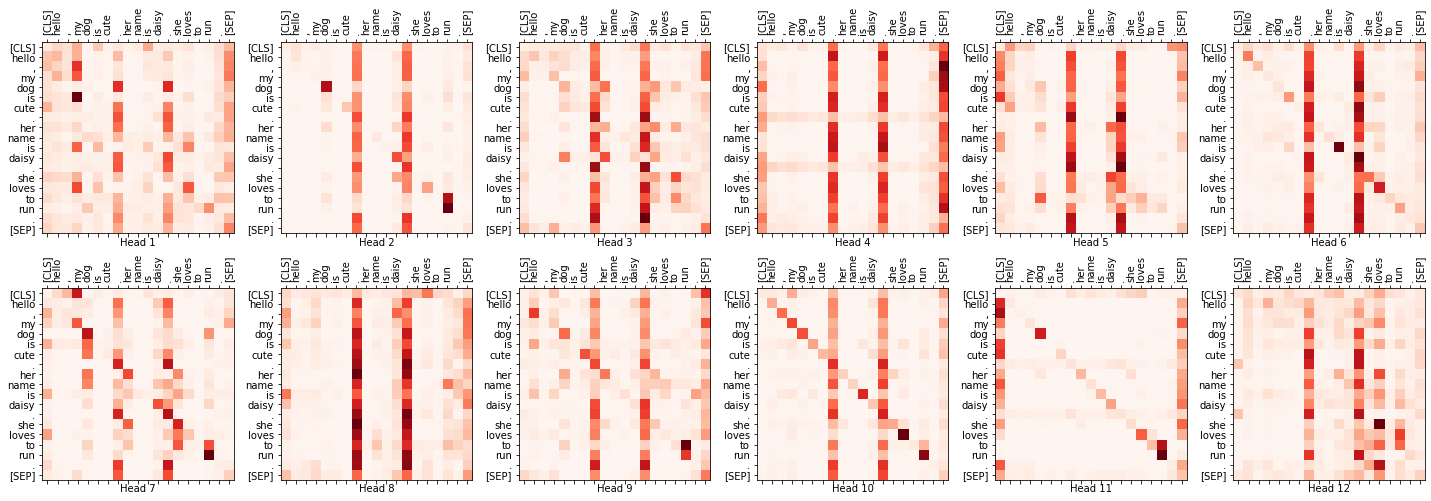

Layer 10 gradient based attention maps:


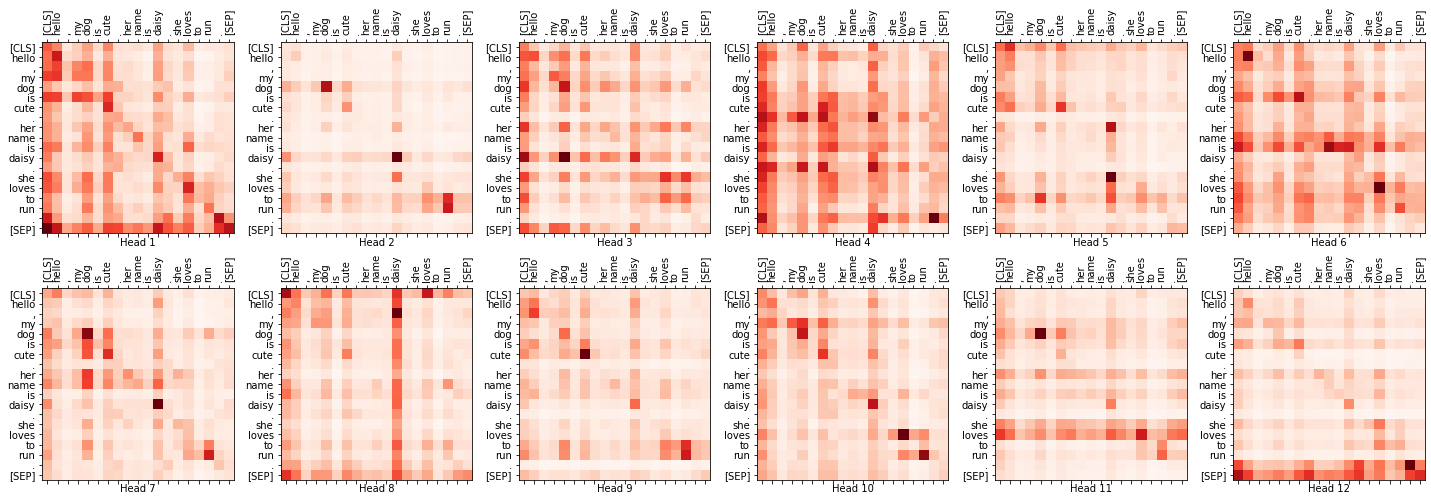

Layer 11 attention maps:


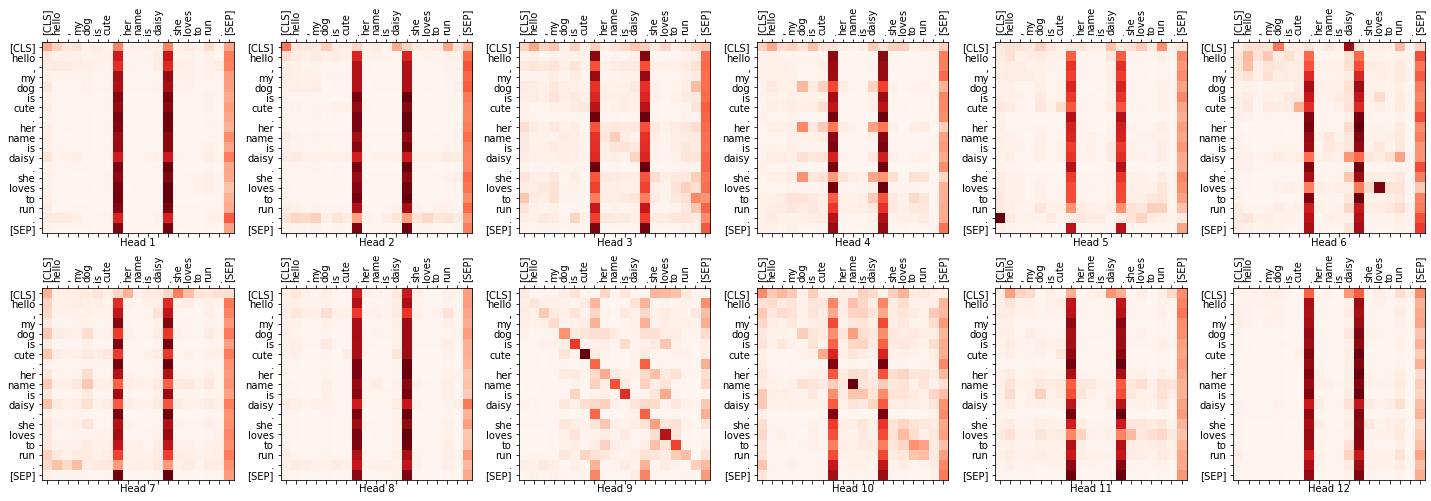

Layer 11 gradient based attention maps:


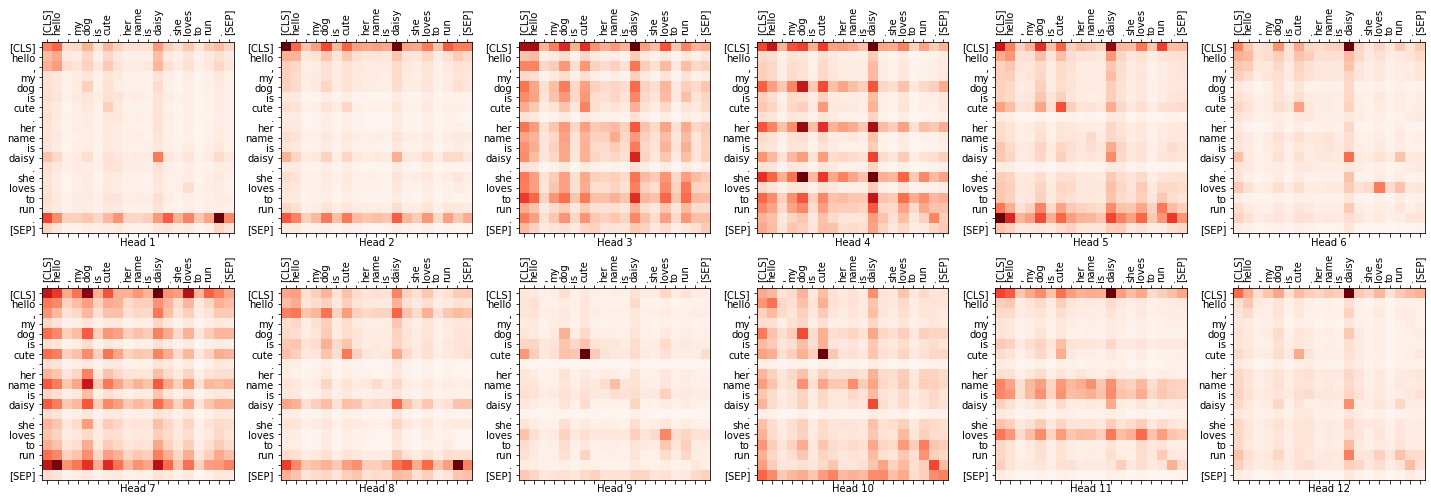

In [74]:
# grad based attentions
for i in range(12):
    print(f'Layer {i} attention maps:')
    plot_attention_weights(attentions, tokens, layer=i, layout=(2,6), figsize=(20,7))
    print(f'Layer {i} gradient based attention maps:')
    plot_attention_weights(grad_based_attentions, tokens, layer=i, layout=(2,6), figsize=(20,7))
    # plot_attention_weights(grad_based_attentions, tokens, layer=i, layout=(2,6), figsize=(20,7), 
    #                        cmap='bwr', norm=colors.DivergingNorm(vcenter=0.0))